In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import ast
from fastprogress import progress_bar
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
from skimage import io, transform
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import urllib.request

from preprocess import load, generator
from utils import plot_labelled_image, plot_labelled_sample

In [23]:
images_path = '../data/images/'
labels_path = '../data/landmarks.csv'
target_size = 160

In [24]:
X, y = load(images_path, labels_path, target_size)

X_train, X_test_, y_train, y_test_ = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_, y_test_, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(4192, 160, 160, 3) (898, 160, 160, 3) (899, 160, 160, 3)


In [25]:
y.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y
filename,,,,,,,,,,,,,,,,,,,,,
Abyssinian_1.jpg,90.400002,52.399998,90.400002,31.199999,101.333328,40.400002,111.733330,30.799999,111.199997,52.399998,...,96.533340,48.800003,104.533325,49.200001,97.600006,59.599998,99.466667,57.600002,102.666664,59.599998
Abyssinian_100.jpg,63.350254,63.360001,76.751266,32.639999,99.492386,40.000000,134.010147,25.280001,131.573608,57.600002,...,92.588837,61.440002,118.984772,59.200001,102.741119,81.279999,111.269035,78.400002,118.578682,80.000000
Abyssinian_102.jpg,30.400000,80.860214,8.960000,27.526882,62.719997,37.161289,101.440002,11.354838,101.759995,65.720428,...,50.560001,72.258064,80.319992,69.161293,57.600002,105.978500,67.839996,101.161285,77.760002,102.881714
Abyssinian_103.jpg,85.760002,75.213676,77.760002,46.039886,96.639999,46.951565,113.279999,32.364670,115.520004,65.185181,...,95.039993,71.111115,107.840004,67.464386,101.440002,87.977211,104.320000,86.609688,108.160004,85.698006
Abyssinian_105.jpg,80.319992,72.959999,76.479996,45.226665,97.600006,45.226665,118.720001,45.226665,114.239998,71.680000,...,90.240005,77.653336,104.960007,77.653336,93.760002,95.573334,97.279999,95.146667,100.800003,96.000000


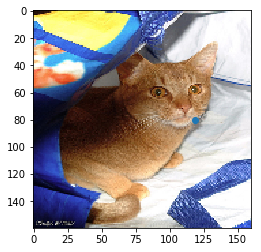

In [47]:
plt.imshow(X[1])
plt.scatter(y.iloc[1][20], y.iloc[1][21])

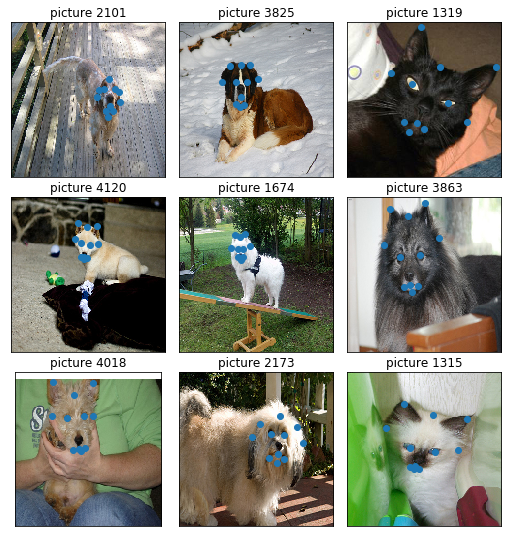

In [10]:
plot_labelled_sample(X_train, y_train, target_size, False)

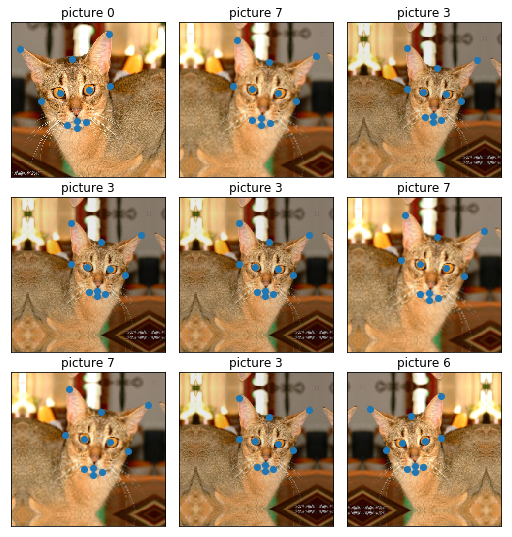

In [11]:
for a, b in generator(X[2:3], y.iloc[2:3], 9, target_size):
    plot_labelled_sample(a, b, target_size)   
    break

In [41]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [39]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(
                        self.root_dir,
                        self.landmarks_frame.iloc[idx, 0]
        )
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (400, 600, 3) (11, 2)


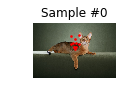

1 (500, 394, 3) (11, 2)


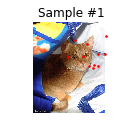

2 (465, 500, 3) (11, 2)


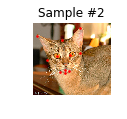

3 (351, 500, 3) (11, 2)


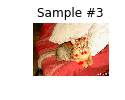

In [40]:
face_dataset = FaceLandmarksDataset(csv_file='../data/cleaned_labels.csv',
                                    root_dir='../data/images/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [13]:
y.to_csv('../data/cleaned_labels.csv')

In [14]:
pd.read_csv('../data/cleaned_labels.csv', index_col='filename').head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y
filename,,,,,,,,,,,,,,,,,,,,,
Abyssinian_1.jpg,90.400002,52.399998,90.400002,31.199999,101.333328,40.400002,111.733330,30.799999,111.199997,52.399998,...,96.533340,48.800003,104.533325,49.200001,97.600006,59.599998,99.466667,57.600002,102.666664,59.599998
Abyssinian_100.jpg,63.350254,63.360001,76.751266,32.639999,99.492386,40.000000,134.010147,25.280001,131.573608,57.600002,...,92.588837,61.440002,118.984772,59.200001,102.741119,81.279999,111.269035,78.400002,118.578682,80.000000
Abyssinian_102.jpg,30.400000,80.860214,8.960000,27.526882,62.719997,37.161289,101.440002,11.354838,101.759995,65.720428,...,50.560001,72.258064,80.319992,69.161293,57.600002,105.978500,67.839996,101.161285,77.760002,102.881714
Abyssinian_103.jpg,85.760002,75.213676,77.760002,46.039886,96.639999,46.951565,113.279999,32.364670,115.520004,65.185181,...,95.039993,71.111115,107.840004,67.464386,101.440002,87.977211,104.320000,86.609688,108.160004,85.698006
Abyssinian_105.jpg,80.319992,72.959999,76.479996,45.226665,97.600006,45.226665,118.720001,45.226665,114.239998,71.680000,...,90.240005,77.653336,104.960007,77.653336,93.760002,95.573334,97.279999,95.146667,100.800003,96.000000


In [44]:
landmarks_frame = pd.read_csv('../data/cleaned_labels.csv')

n = 22
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].values
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: Abyssinian_124.jpg
Landmarks shape: (11, 2)
First 4 Landmarks: [[50.45044708 50.87999725]
 [43.24324036 31.04000092]
 [71.59159088 36.47999954]
 [98.97897339 32.31999969]]


# Load uploaded images and labels

In [258]:
all_data = pd.read_json('https://content.mytalkingpet.app/templates?_limit=100')

all_data = all_data[[
    'uploadedImage',
    'leftHeadPoint', 
    'leftEarPoint',
    'topHeadPoint',
    'rightEarPoint',
    'rightHeadPoint',
    'chinPoint',
    'leftEyePoint',
    'rightEyePoint',
    'leftMouthPoint',
    'centreMouthPoint',
    'rightMouthPoint'
]]

all_data = all_data.dropna()

kp_cols = [
    'leftHeadPoint', 
    'leftEarPoint',
    'topHeadPoint',
    'rightEarPoint',
    'rightHeadPoint',
    'chinPoint',
    'leftEyePoint',
    'rightEyePoint',
    'leftMouthPoint',
    'centreMouthPoint',
    'rightMouthPoint'
]

def items(a_set):
    xy = list()
    for letter in a_set:
        xy.insert(0, letter)
    if len(a_set) < 2:
        xy.append(xy[0])
    return xy

for col in kp_cols:
    all_data[col] = all_data[col].apply(ast.literal_eval)
    all_data[col] = all_data[col].apply(items)

    all_data[col+'_x'], all_data[col+'_y'] = zip(*all_data[col])
    
    all_data = all_data.drop(col, axis=1)

uploadImageDf = pd.DataFrame(all_data['uploadedImage'].values.tolist())
all_data['hash'] = uploadImageDf['hash'].values

all_data = all_data.drop('uploadedImage', axis=1)
all_data = all_data.set_index('hash')

In [241]:
for i in progress_bar(range(all_data.shape[0])):
    urllib.request.urlretrieve(
        all_data.iloc[i]['uploadedImage']['url'], 
        "../data/uploaded_images/{}.png".format(all_data.iloc[i]['hash'])
    )

In [ ]:
images_path = '../data/uploaded_images/'
labels_path = '../data/landmarks.csv'
target_size = 80

In [ ]:
plot_labelled_sample(X_train, y_train, target_size, False)